In [1]:
#limpio la memoria
rm(list=ls())
gc()
tInicio       <-  Sys.time()
#cargo librerias
library("data.table")
library("ROCR")
library("rpart")
library("rpart.plot")
library("caret")

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,602641,32.2,1286551,68.8,1286551,68.8
Vcells,1082495,8.3,8388608,64.0,1632265,12.5


Loading required package: ggplot2

Loading required package: lattice



In [2]:
#setwd("~/cloudL/UA/labo2022/")
setwd("C:/Users/sackp/OneDrive/LAB")

#Parametros entrada

#kcarpeta_datasets    <- "../input/laboratorio-de-implementacion-i-2021/"   #KAGGLE
kcarpeta_datasets    <- "./datasets/"                          #VM o Ubuntu

#Archivo con datos etiquetados para entrenamiento
karchivo_entrada      <-  paste0(kcarpeta_datasets, "competencia2_2022.csv.gz")

#Formato para submit en Kaggle
#karchivo_score      <-  "../input/uamds2020ldi1f1/Sample_201910_Fase_I.txt"

#Separador de campos en archivos
kcampos_separador     <-  "\t"

#Campo que identifica las muestras
kcampo_id             <-  "numero_de_cliente"

#Campo que contiene la clase a estimar
kclase_nomcampo       <-  "clase_binaria"

#Valor de interés
kclase_valor_positivo <-  "SI"

#Campos a borrar para el entrenamiento
kcampos_a_borrar      <-  c(kcampo_id,kclase_nomcampo,"foto_mes")

#Campo que contendrá a la variable objetivo generada
kobjetivo             <-  "clase"

#Identificación del modelo
kmodelo               <-  "02-RPART"

#Ganancia por TP
kTPGain               <-  78000

#Pérdida por FP
kFPGain               <-  -2000

#Establezco semilla aleatoria
set.seed(699953)



In [3]:
#cargo los datos
dataset <- fread(karchivo_entrada)

#Para hacer pruebas rapidas puedo reducir el dataset a una fraccion
#subsample <- sample(1:nrow(dataset), .1 * nrow(dataset))
#dataset <- dataset[subsample,]

dataset[ foto_mes==202001, clase_binaria :=  ifelse( clase_ternaria=="CONTINUA", "NO", "SI" ) ]

dtrain  <- dataset[ foto_mes==202001, ]  #defino donde voy a entrenar

train_rows <- createDataPartition(dtrain$clase_binaria, p = .66, list = FALSE)

#train_rows <- sample(1:nrow(dataset), .66 * nrow(dataset))
dtest <- dtrain[-train_rows,]
dtrain <- dtrain[train_rows,]

dataset[ foto_mes==202101, clase_binaria :=  ifelse( clase_ternaria=="CONTINUA", "NO", "SI" ) ]

dapply  <- dataset[ foto_mes==202101, ]   #defino donde voy a aplicar el modelo

dtrain

numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,⋯,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo,clase_ternaria,clase_binaria
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<chr>,<chr>
31115668,202001,1,0,0,55,120,681.02,4697.59,369.91,⋯,0.00,NA,NA,3631,NA,NA,NA,0.00,CONTINUA,NO
31117415,202001,1,0,1,59,41,190.63,11223.31,1642.93,⋯,0.00,-68540.18,0.00,1207,41808.50,16,0,2791.74,CONTINUA,NO
31118204,202001,1,0,1,67,246,5799.87,30212.22,4097.85,⋯,0.00,-37942.67,0.00,2755,38912.98,27,0,3483.81,CONTINUA,NO
31118490,202001,1,0,1,60,266,7945.29,86605.75,404.72,⋯,0.00,-257.59,0.00,7208,254.54,3,0,11.73,CONTINUA,NO
31118757,202001,1,0,1,59,263,1222.20,15387.68,1925.46,⋯,0.00,-12118.72,0.00,3963,16724.75,23,0,2205.24,CONTINUA,NO
31120000,202001,1,0,1,69,122,2768.30,41097.20,2250.58,⋯,0.00,-95116.77,0.00,3078,39916.06,30,0,6615.72,CONTINUA,NO
31121767,202001,1,0,1,59,178,1146.40,25590.59,968.90,⋯,0.00,-25294.92,0.00,3396,28278.24,17,0,1759.50,CONTINUA,NO
31122280,202001,1,0,1,53,42,508.13,38580.15,270.77,⋯,0.00,-13600.60,11.71,1257,15256.12,11,0,1689.12,CONTINUA,NO
31124994,202001,1,0,1,57,268,1469.71,67443.42,228.58,⋯,0.00,-10624.51,0.00,7715,11008.12,7,0,434.01,CONTINUA,NO


In [4]:
#Funcion que calcula la ganancia para una prediccion y valores reales
fmetrica_ganancia_rpart  = function( probs, clases, pclase_valor_positivo )
{
 
  return(  sum(    (probs > 1/40 ) * 
                   ifelse( clases== pclase_valor_positivo, kTPGain, kFPGain )   
              )
         )
}

In [5]:
# Funcion que entrena el arbol y luego determina la ganancia sobre el set de test
modelo_rpart_ganancia = function( ptrain, ptest, pmaxdepth, pminbucket, pminsplit, pcp )
{

  modelo   <-  rpart("clase_binaria ~ . - clase_ternaria",   data = ptrain,  xval=0, maxdepth=pmaxdepth, minbucket=pminbucket, minsplit=pminsplit, cp=pcp)

  #aplico el modelo a datos nuevos
  testing_prediccion  <- predict( modelo, ptest)[, "SI"]
    
  return(fmetrica_ganancia_rpart(testing_prediccion,ptest[,..kclase_nomcampo],"SI"))
  
}

In [6]:
#Cuenta los modelos probados
linea <- 1

#Establece una ganancia inicial muy baja a superar
max_gan <- -100000000

#For anidados para grid search 
#for( vcp in c( 0, 0.01, 0.001)) #Complexity Factor
for( vcp in c( 0)) #Complexity Factor
for( vmaxdepth in  c(4) ) #max Depth
#for( vmaxdepth in  c(4,8,14,16) ) #max Depth
for( vminsplit in  c(2 ) ) #Min Split
#for( vminsplit in  c(2, 4, 8, 10, 15, 20, 30, 50, 100, 150, 200, 300, 400 ) ) #Min Split
for( vminbucket  in  unique( as.integer(c(1)) ) ) #Min Bucket
#for( vminbucket  in  unique( as.integer(c(1,2,3,4,5,  vminsplit/10, vminsplit/5, vminsplit/3, vminsplit/2 )) ) ) #Min Bucket
{ 

    #Muestra los parametros a testear
    message(paste('Intentando',vcp,vminsplit,vminbucket,vmaxdepth))
    #Llama a la funcion que entrena el modelo y calcula la ganancia para esos parametros
    res <- modelo_rpart_ganancia( dtrain, dtest, 
                                  pmaxdepth=vmaxdepth, pminbucket=vminbucket, pminsplit=vminsplit, pcp=vcp )

  
    #Verifica si se supero la mejor ganancia hasta el momento. En caso de haberla superado graba los hiperparametros nuevos
    if (res>max_gan) {
      max_gan <- res
      message(paste("Nuevo Maximo: ", res*3, vcp,vminsplit,vminbucket,vmaxdepth))
      pcp<-vcp
      pminsplit<-vminsplit
      pminbucket<-vminbucket
      pmaxdepth<-vmaxdepth
  }
  #Muestra al ganancia de la iteracion
  message(paste('Ganancia:',res*3,'Ganancia Maxima',max_gan*3))
    
  linea <- linea+1


}

Intentando 0 2 1 4

Nuevo Maximo:  40236000 0 2 1 4

Ganancia: 40236000 Ganancia Maxima 40236000



In [13]:
#Entrena el modelo con el dataset completo
t0       <-  Sys.time()
modelo   <-  rpart("clase_binaria ~ .",   data = dtrain,  xval=0, maxdepth=pmaxdepth, minbucket=pminbucket, minsplit=pminsplit, cp=pcp)
t1       <-  Sys.time()

tcorrida <-  as.numeric( t1 - t0, units = "secs")
print( tcorrida)

[1] 1.794992


In [8]:
#Detalles del modelo
modelo

n= 94334 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

1) root 94334 746 NO (0.992091929 0.007908071)  
  2) clase_ternaria=CONTINUA 93588   0 NO (1.000000000 0.000000000) *
  3) clase_ternaria=BAJA+1,BAJA+2 746   0 SI (0.000000000 1.000000000) *

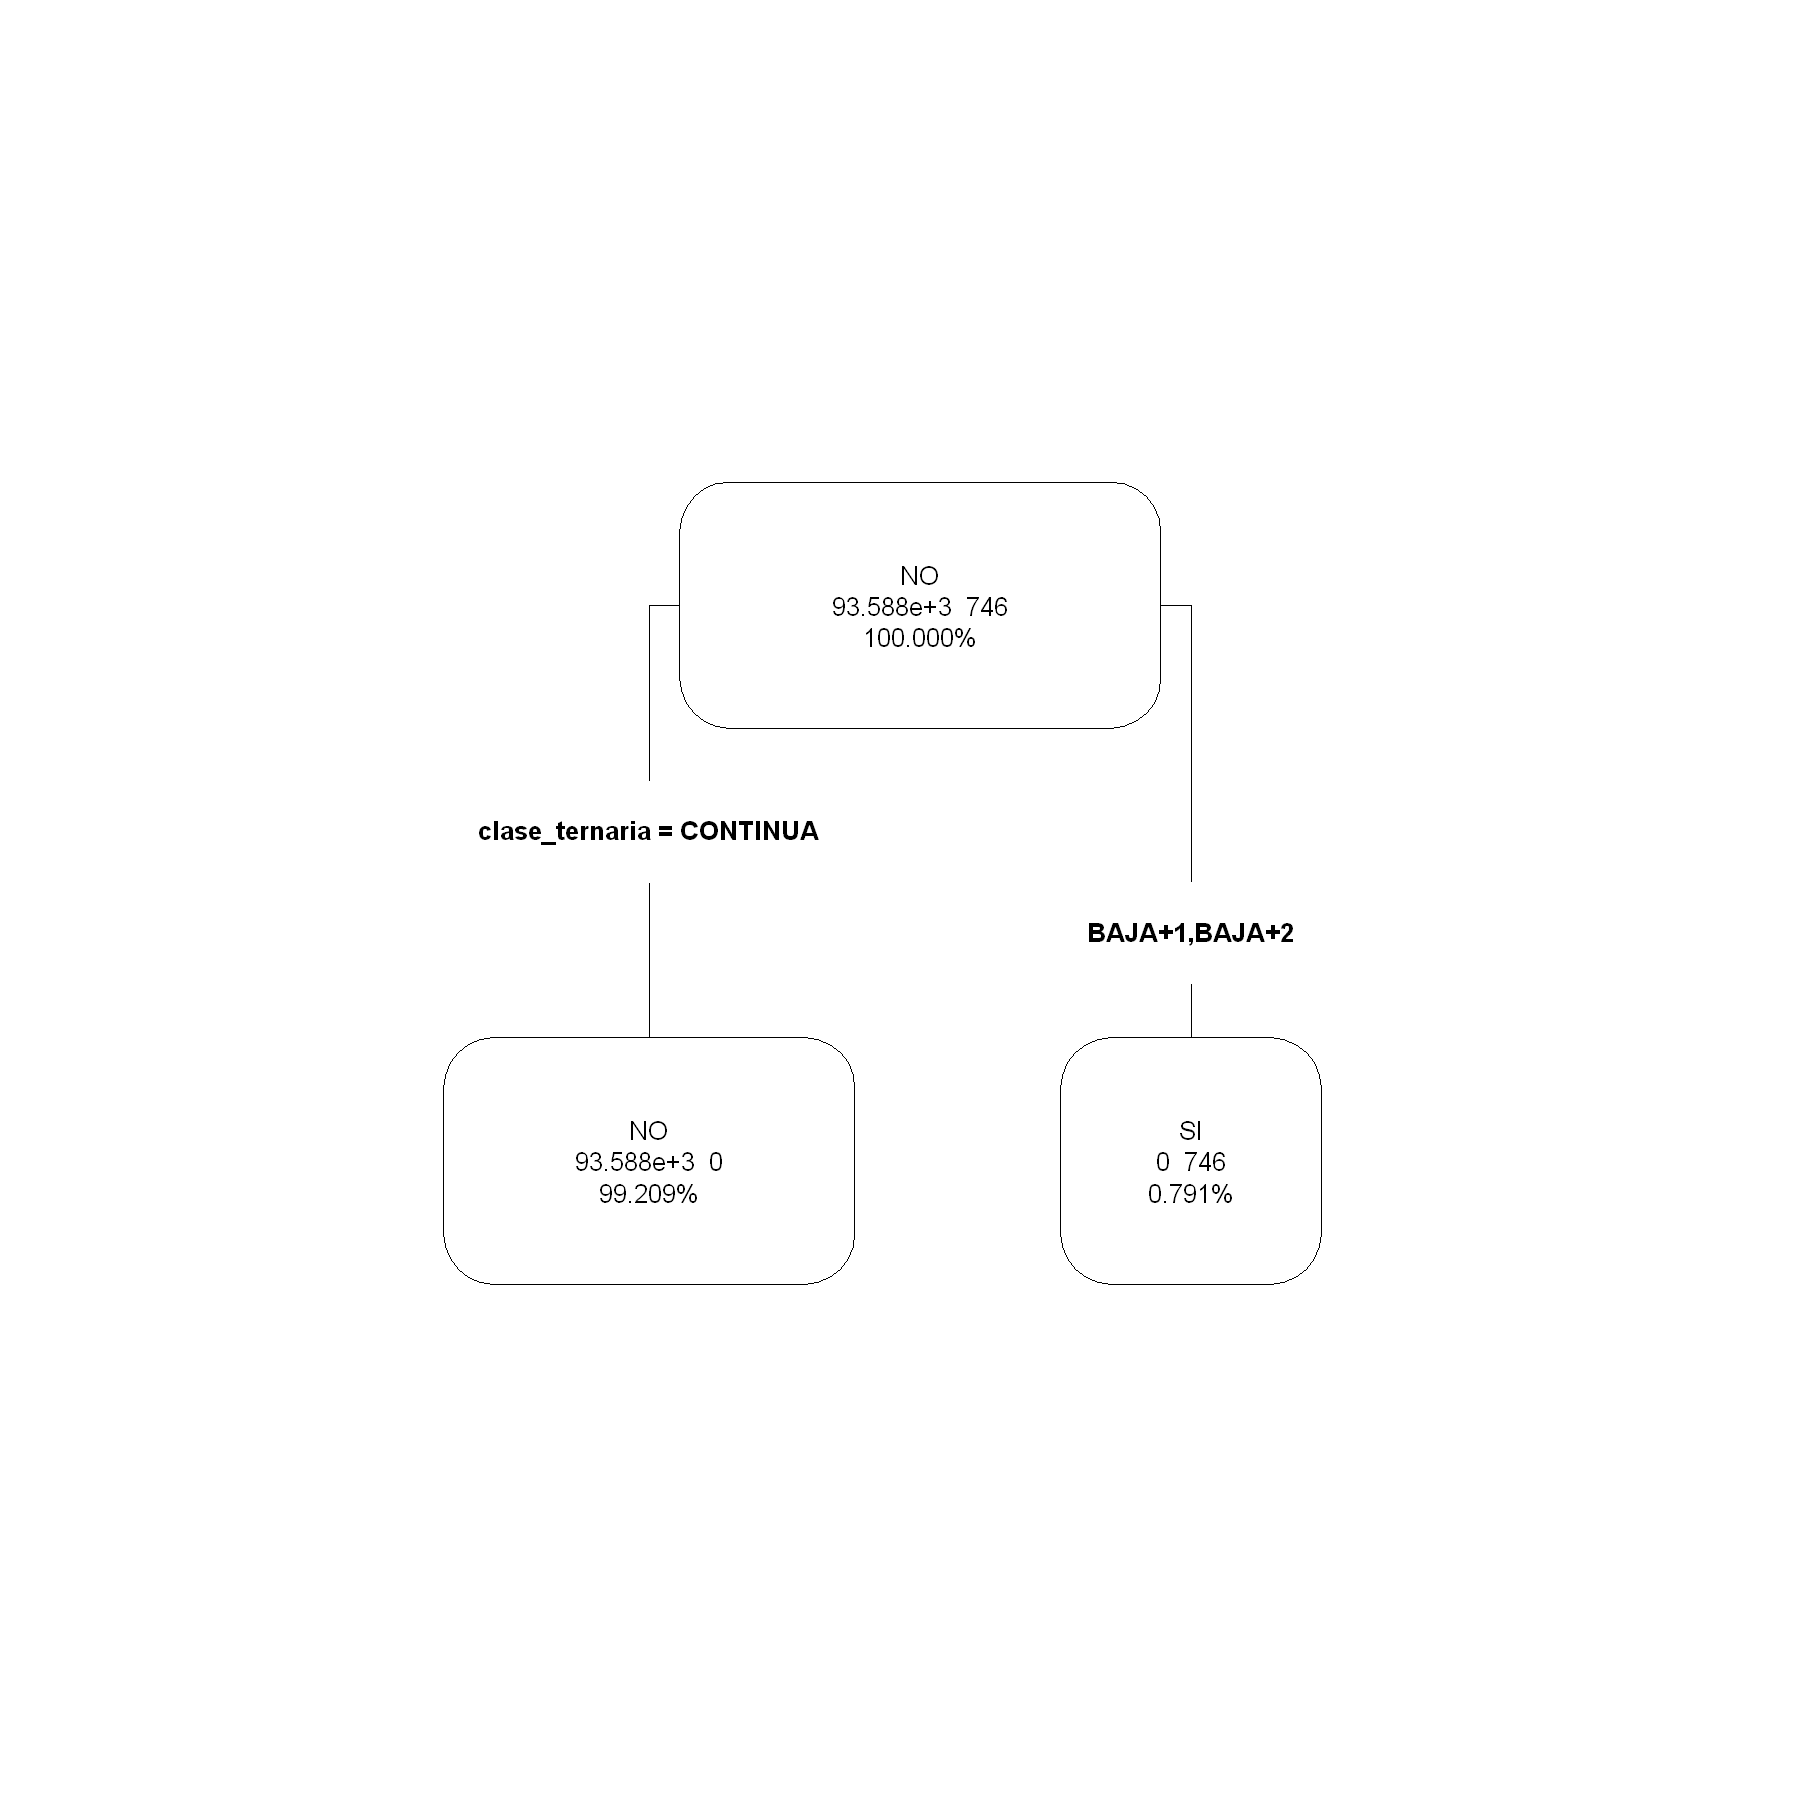

In [9]:
#Arbol generado
options(repr.plot.width=15, repr.plot.height=15)
prp(modelo, extra=101, digits=5, branch=1, type=4, varlen=0, faclen=0, tweak=1.3)

In [14]:
prediccion  <- predict( modelo, dapply , type = "prob") #aplico el modelo
dapply[ , prob_baja2 := prediccion[, "SI"] ]
dapply[ , Predicted  := as.numeric(prob_baja2 > 1/40) ]
dir.create( "./exp/Turquesa" )
fwrite( dapply[ , list(numero_de_cliente, Predicted) ], #solo los campos para Kaggle
        file= "./exp/Turquesa/SearchGrid.csv", 
        sep= "," )

In [15]:
tFinal       <-  Sys.time()
tcorridaFinal <-  as.numeric( tInicio - tFinal, units = "secs")
print( tcorridaFinal)

[1] -973.0227
